In [1]:
import networkx as nx
from qiskit import execute, Aer, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
graph = nx.Graph()
graph.add_nodes_from([0,1,2])
graph.add_edges_from([(0,1),(1,2)])

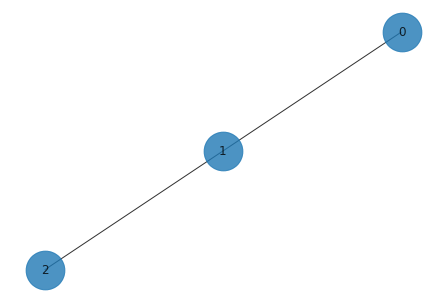

In [3]:
nx.draw(graph, with_labels=True, alpha=0.8, node_size=1500)

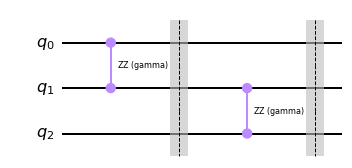

In [4]:
from qiskit.circuit import Parameter

def problem_circuit(graph, gamma):
    
    qc_p = QuantumCircuit(len(graph.nodes()))
    for edge in list(graph.edges()):
        qc_p.rzz(gamma, edge[0], edge[1])
        qc_p.barrier()
        
    return qc_p

gamma = Parameter("gamma")
qc_p = problem_circuit(graph, gamma)
qc_p.draw("mpl")

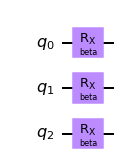

In [5]:
def ansatz_circuit(graph, beta):
    qc_a = QuantumCircuit(len(graph.nodes()))
    for i in range(len(graph.nodes())):
        qc_a.rx(beta, i)
    
    return qc_a

beta = Parameter("beta")
ansatz_circuit(graph, beta).draw("mpl")

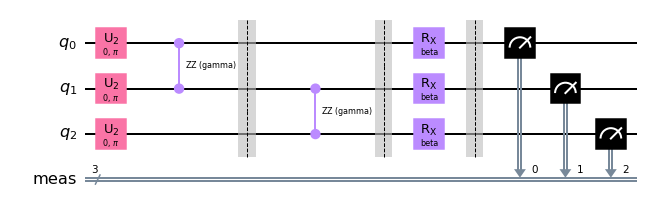

In [6]:
def get_circuit(graph, beta, gamma):
    cnt_qubits = len(graph.nodes())
    qc_qaoa = QuantumCircuit(cnt_qubits)
    
    # initial_state
    qc_qaoa.h(range(cnt_qubits))

    # append problem circuit
    qc_qaoa.append(problem_circuit(graph, gamma), range(cnt_qubits))
    
    # append ansatz circuit
    qc_qaoa.append(ansatz_circuit(graph, beta), range(cnt_qubits))
    
    qc_qaoa.measure_all()
    return qc_qaoa

beta = Parameter("beta")
gamma = Parameter("gamma")
get_circuit(graph, beta, gamma).decompose().draw("mpl")

In [7]:
def get_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for solution, count in counts.items():
        performance = 0
        for i, j in graph.edges():
            if solution[i] != solution[j]:
                performance -= 1

        avg += performance * count
        sum_count += count
    return avg/sum_count

In [8]:
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

def calculate_circ(graph, beta, gamma, backend, shots):
    qc = get_circuit(graph, beta, gamma)
    result = execute(qc,backend, shots=shots).result()
    return get_expectation(result.get_counts(), graph)

def qaoa(graph):
    backend = Aer.get_backend('qasm_simulator')
    
    result = minimize(
        # callable function
        lambda thetas: calculate_circ(graph, thetas[0], thetas[1], backend,
                                      1000),
        # initial guess on beta and gamma
        [1.0, 1.0],
        # optimization method
        method='COBYLA')
    
    return result

result = qaoa(graph)
print(result)

     fun: -1.584
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.54792501, 0.97652106])


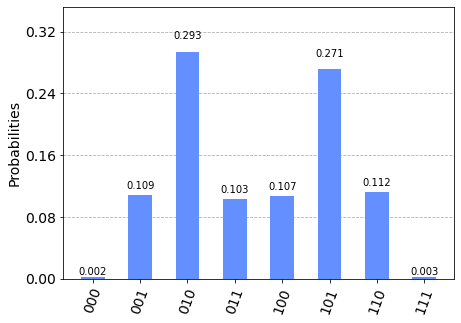

In [9]:
qc_res = get_circuit(graph, result.x[0], result.x[1])
counts = execute(qc_res, Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(counts)

### Using Qiskit to directly solve Maxcut problem

In [12]:
from qiskit_optimization.applications import Maxcut
from qiskit.utils import QuantumInstance
from qiskit import Aer
import pandas as pd

In [13]:
hero_network = pd.read_csv("data/hero-network.csv")
hero_network.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [14]:
heroes = {'MEDUSA/MEDUSALITH AM','ARCLIGHT/PHILLIPA SO','WOLVERINE/LOGAN ','SCARLET WITCH/WANDA ',
          'ARAGORN','OVERMIND/GROM','BATTLEAXE/','ION/', 'PINK PEARL/'}
relations = hero_network[(hero_network.hero1.isin(heroes)) & (hero_network.hero2.isin(heroes))]
relations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 895 to 573288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero1   103 non-null    object
 1   hero2   103 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [15]:
graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')
matrix = nx.to_pandas_adjacency(graph, dtype=int)
adjacency = matrix.to_numpy()

max_cut = Maxcut(adjacency)

qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()

backend = Aer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)

In [18]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

qaoa = QAOA(quantum_instance=quantum_instance)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
print(qaoa_optimizer.solve(qp))

fval=9.0, x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, x_8=0.0, status=SUCCESS


#### Weighted Max-cut

In [22]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is D4A5-1DBC

 Directory of C:\Users\ganiy\Documents\qml-optimization

12/25/2022  12:47 PM    <DIR>          .
12/25/2022  12:47 PM    <DIR>          ..
12/25/2022  11:46 AM    <DIR>          .ipynb_checkpoints
12/11/2022  06:30 PM    <DIR>          data
12/22/2022  03:06 PM            72,049 ground_state.ipynb
12/22/2022  03:06 PM            26,494 hamiltonian-decompostion.ipynb
12/23/2022  04:33 PM           372,981 lockdown.ipynb
12/14/2022  12:57 PM            75,318 Part1.ipynb
12/25/2022  12:47 PM            70,145 qaoa.ipynb
12/06/2022  09:14 PM                18 README.md
               6 File(s)        617,005 bytes
               4 Dir(s)  25,634,381,824 bytes free


In [23]:
#data = pd.read_csv("data/hero−network.csv")
count_series1 = hero_network.groupby(['hero1']).size()
count_series2 = hero_network.groupby(['hero2']).size()

In [24]:
appearences = count_series1.add(count_series2, fill_value=0)
appearences = appearences.sort_values(ascending=False)

In [27]:
appearences.head(10)

CAPTAIN AMERICA         16499.0
SPIDER-MAN/PETER PAR    13717.0
IRON MAN/TONY STARK     11817.0
THOR/DR. DONALD BLAK    11427.0
THING/BENJAMIN J. GR    10681.0
WOLVERINE/LOGAN         10353.0
HUMAN TORCH/JOHNNY S    10237.0
SCARLET WITCH/WANDA      9911.0
MR. FANTASTIC/REED R     9775.0
VISION                   9696.0
dtype: float64

In [28]:
n = 12
topheroes = appearences[:n].keys().to_list()
topheroes

['CAPTAIN AMERICA',
 'SPIDER-MAN/PETER PAR',
 'IRON MAN/TONY STARK ',
 'THOR/DR. DONALD BLAK',
 'THING/BENJAMIN J. GR',
 'WOLVERINE/LOGAN ',
 'HUMAN TORCH/JOHNNY S',
 'SCARLET WITCH/WANDA ',
 'MR. FANTASTIC/REED R',
 'VISION ',
 'INVISIBLE WOMAN/SUE ',
 'BEAST/HENRY &HANK& P']

In [29]:
relations = hero_network[(hero_network.hero1.isin(topheroes) & hero_network.hero2.isin(topheroes))]

grouped_relations = relations.groupby(['hero1','hero2']).size().reset_index().rename(columns={0:'count'})
grouped_relations.head()

,hero1,hero2,count
0,BEAST/HENRY &HANK& P,CAPTAIN AMERICA,92
1,BEAST/HENRY &HANK& P,HUMAN TORCH/JOHNNY S,31
2,BEAST/HENRY &HANK& P,INVISIBLE WOMAN/SUE,25
3,BEAST/HENRY &HANK& P,IRON MAN/TONY STARK,76
4,BEAST/HENRY &HANK& P,MR. FANTASTIC/REED R,29


In [30]:
grouped_relations.loc[(grouped_relations['hero1'] == 'CAPTAIN AMERICA') &(grouped_relations['hero2'] == 'VISION ') |(grouped_relations['hero2'] == 'CAPTAIN AMERICA') &(grouped_relations['hero1'] == 'VISION ')]

,hero1,hero2,count
21,CAPTAIN AMERICA,VISION,180
112,VISION,CAPTAIN AMERICA,205


In [32]:
import numpy as np
relations['relation'] = [' − '.join(x) for x in np.sort(relations.to_numpy(), axis=1)]

C:\Users\ganiy\AppData\Local\Temp\ipykernel_12256\832748052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relations['relation'] = [' − '.join(x) for x in np.sort(relations.to_numpy(), axis=1)]


In [33]:
summed_relations = relations.groupby(['relation']).size().reset_index().rename(columns={0:'count'})

In [34]:
summed_relations.loc[(summed_relations['relation'] == 'CAPTAIN AMERICA − VISION ') |(summed_relations['relation'] == 'VISION − CAPTAIN AMERICA')]

,relation,count
20,CAPTAIN AMERICA − VISION,385


In [35]:
summed_relations = pd.merge(summed_relations, relations, on='relation',how='right')

In [36]:
sub_graph = nx.from_pandas_edgelist(summed_relations,source='hero1',target='hero2', edge_attr='count')

print(nx.info(sub_graph))
print("\nNetwork density:", nx.density(sub_graph))

Graph with 12 nodes and 67 edges

Network density: 1.0151515151515151


C:\Users\ganiy\AppData\Local\Temp\ipykernel_12256\2352778431.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(sub_graph))


In [37]:
summed_relations.drop(summed_relations[summed_relations['hero1'] == summed_relations['hero2']].index, inplace = True)

In [38]:
sub_graph = nx.from_pandas_edgelist(summed_relations,source='hero1',target='hero2',edge_attr='count')

print(nx.info(sub_graph))
print("\nNetwork density:", nx.density(sub_graph))

Graph with 12 nodes and 66 edges

Network density: 1.0


C:\Users\ganiy\AppData\Local\Temp\ipykernel_12256\305292767.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(sub_graph))


In [41]:
import matplotlib.pyplot as plt

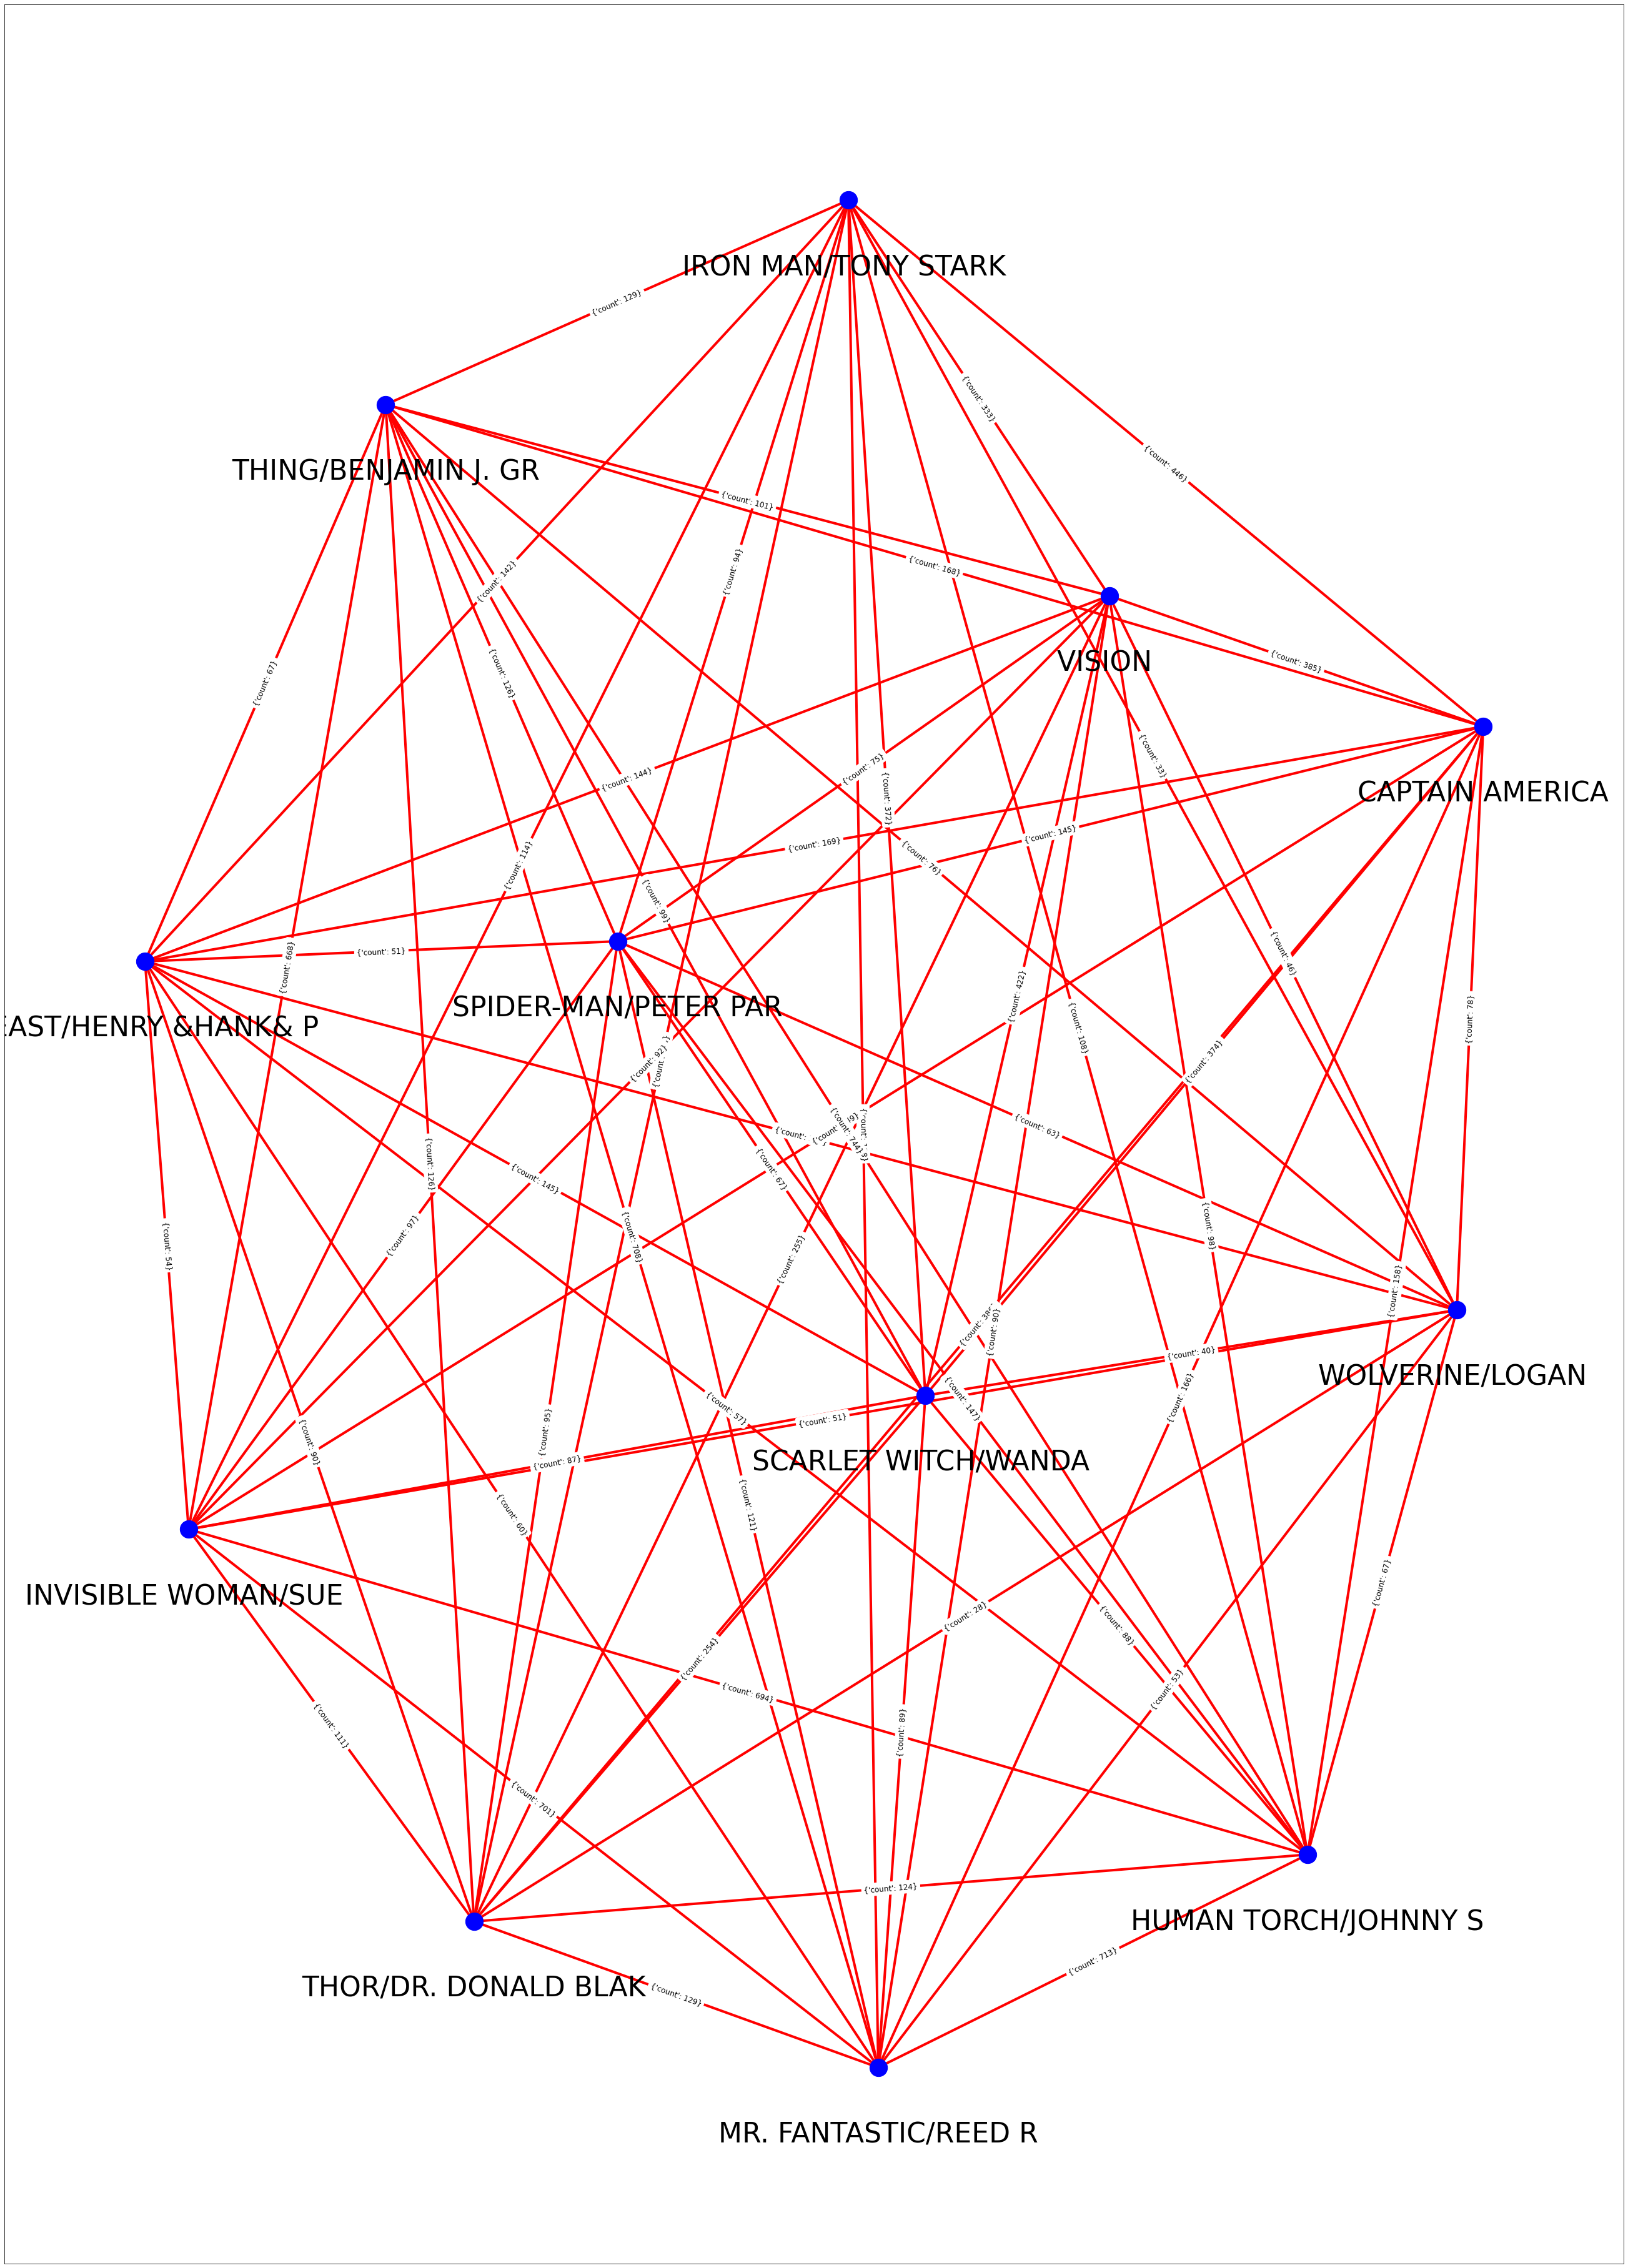

In [43]:
plt.figure(1,figsize=(12,8))
plt.tight_layout()
plt.subplots_adjust(bottom=-5.4, right=1.5, left=-1.5)

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(sub_graph)
pos_nodes = nudge(pos, 0, -0.07)

nx.draw_networkx_nodes(sub_graph, pos=pos, node_color="blue",node_size=800) # default nodes and edges
nx.draw_networkx_edges(sub_graph, pos, width=4, edge_color ="red")
labels=nx.draw_networkx_edge_labels(sub_graph,pos=pos, font_color="#000",font_size=12)
labels=nx.draw_networkx_labels(sub_graph,pos=pos_nodes, font_color="#000",font_size=44)

plt.show()

In [44]:
matrix = nx.to_pandas_adjacency(sub_graph, weight="count", dtype=int)
adjacency = matrix.to_numpy()
adjacency

array([[  0, 372, 142, 446,  33, 333, 128, 129, 114, 344,  94, 108],
       [372,   0, 145, 374,  40, 422,  89,  99,  87, 254,  67,  88],
       [142, 145,   0, 169, 146, 144,  60,  67,  54,  90,  51,  57],
       [446, 374, 169,   0,  78, 385, 166, 168, 149, 386, 145, 158],
       [ 33,  40, 146,  78,   0,  46,  53,  76,  51,  28,  63,  67],
       [333, 422, 144, 385,  46,   0,  90, 101,  92, 255,  75,  98],
       [128,  89,  60, 166,  53,  90,   0, 708, 701, 129, 121, 713],
       [129,  99,  67, 168,  76, 101, 708,   0, 668, 126, 126, 744],
       [114,  87,  54, 149,  51,  92, 701, 668,   0, 111,  97, 694],
       [344, 254,  90, 386,  28, 255, 129, 126, 111,   0,  95, 124],
       [ 94,  67,  51, 145,  63,  75, 121, 126,  97,  95,   0, 147],
       [108,  88,  57, 158,  67,  98, 713, 744, 694, 124, 147,   0]])

In [46]:
max_cut = Maxcut(adjacency)

qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()

backend = Aer.get_backend("statevector_simulator")

quantum_instance = QuantumInstance(backend)

qaoa = QAOA(quantum_instance=quantum_instance)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
sol = qaoa_optimizer.solve(qp)
sol

<MinimumEigenOptimizationResult: fval=7765.0, x_0=0.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=1.0, x_9=0.0, x_10=1.0, x_11=0.0, status=SUCCESS>

In [47]:
print(sol)

fval=7765.0, x_0=0.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=1.0, x_9=0.0, x_10=1.0, x_11=0.0, status=SUCCESS
